## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Используя исторические данные, необходимо построить модель для определения стоимости.

## 1. Изучение и подготовка данных из файла

In [1]:
import pandas as pd 
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy import stats as st
from sklearn import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from catboost.utils import eval_metric
from catboost import Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from time import time
import xgboost as xgb
import timeit

Изучим имеющиеся исторические данные:

In [2]:
try:
    df = pd.read_csv("C:/Users/dimil/OneDrive/Desktop/autos.csv")
except:
    df = pd.read_csv('/datasets/autos.csv')

df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Наблюдается значительное количество пропущенных значений по целому ряду признаков. Количество фотографий автомобиля равно 0 для всех объектов.

Проверим временные границы создания объявлений:

In [5]:
df['DateCreated'].max()

'2016-04-07 00:00:00'

In [6]:
df['DateCreated'].min()

'2014-03-10 00:00:00'

Заменим отсутствующие значения для каждого из столбцов:

In [7]:
df['VehicleType'] = df['VehicleType'].fillna('unknown_type')
df['Gearbox'] = df['Gearbox'].fillna('unknown_type')
df['Model'] = df['Model'].fillna('unknown_model')
df['FuelType'] = df['FuelType'].fillna('unknown_fuel')
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

Перед обучением моделей удалим имеющиеся в датасете выбросы: 

<AxesSubplot:>

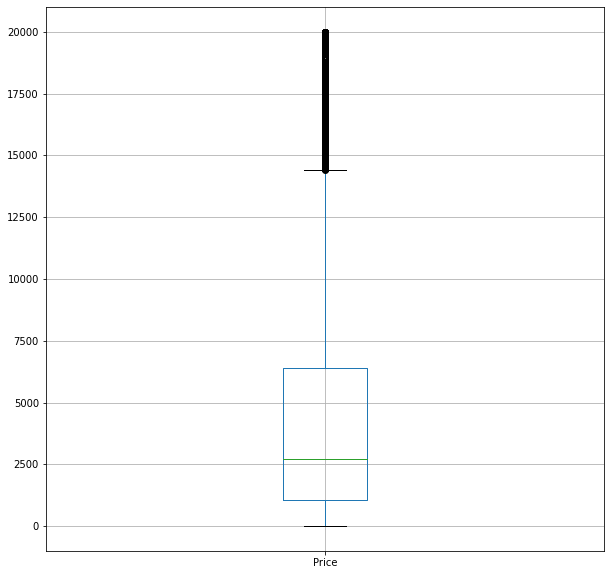

In [8]:
df.boxplot('Price',figsize=(10,10))

In [9]:
df.drop(df[df['Price'] < 1050].index, inplace=True)

<AxesSubplot:>

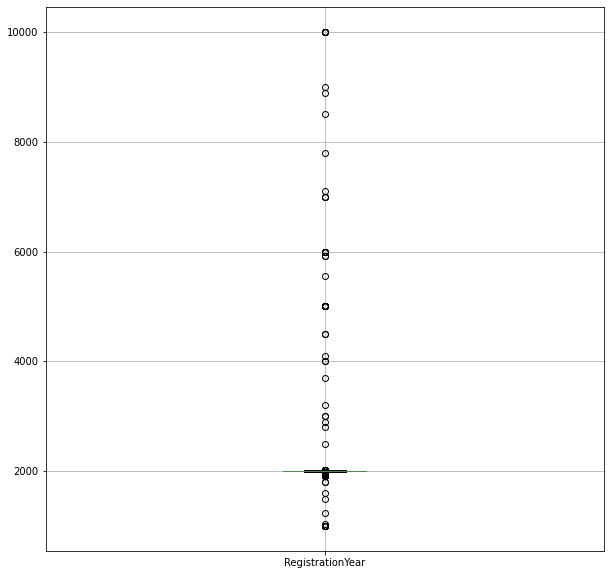

In [10]:
df.boxplot('RegistrationYear',figsize=(10,10))

In [11]:
df.drop(df[(df['RegistrationYear'] > 2016)|(df['RegistrationYear'] < 1950)].index, inplace=True)

<AxesSubplot:>

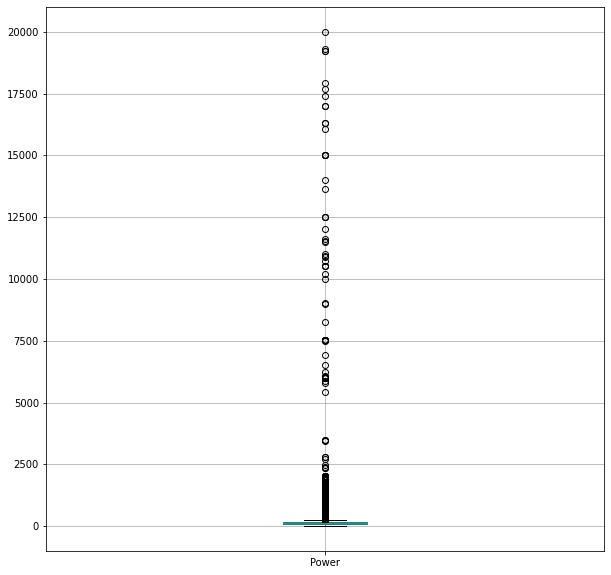

In [12]:
df.boxplot('Power',figsize=(10,10))

In [13]:
df.drop(df[(df['Power'] > 1000)|(df['Power'] < 100)].index, inplace=True)

<AxesSubplot:>

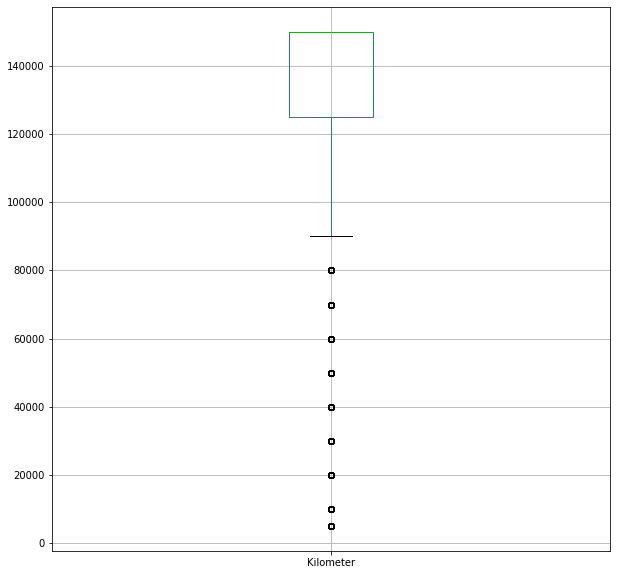

In [14]:
df.boxplot('Kilometer',figsize=(10,10))

<AxesSubplot:>

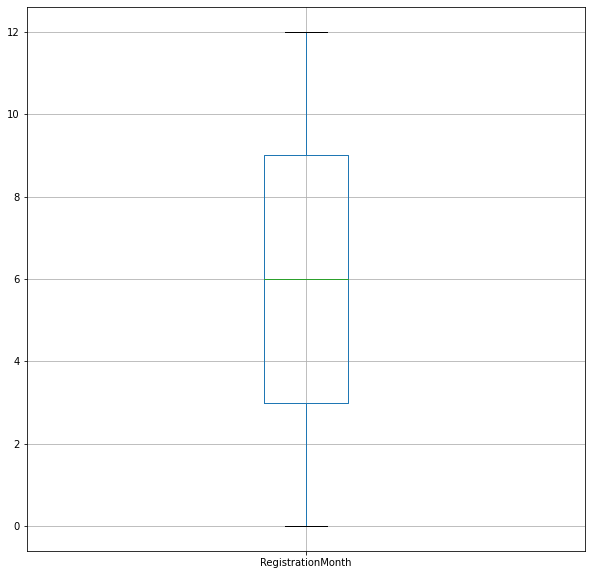

In [15]:
df.boxplot('RegistrationMonth',figsize=(10,10))

In [16]:
df.drop(df[df['RegistrationMonth'] == 0].index, inplace=True)

In [17]:
df.drop(df[(df['RegistrationMonth'] > 4)&(df['RegistrationYear'] == 2016)].index, inplace=True)

<AxesSubplot:>

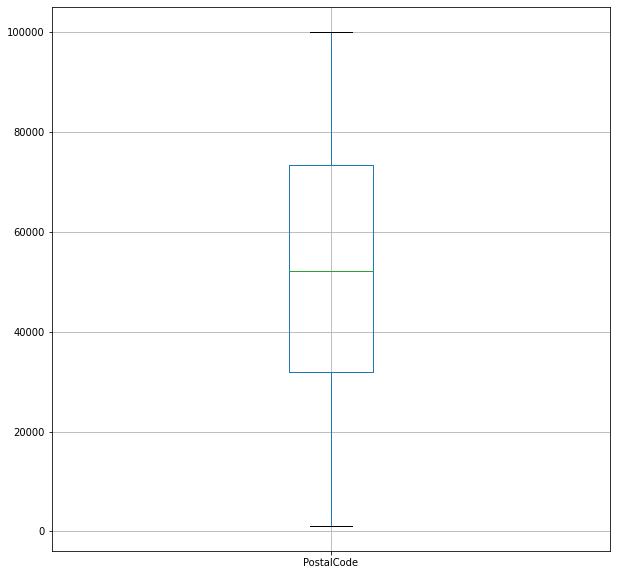

In [18]:
df.boxplot('PostalCode',figsize=(10,10))

In [19]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,161073.000000,161073.000000,161073.000000,161073.000000,161073.000000,161073.0,161073.000000
mean,6906.467633,2004.106585,151.558573,129891.974446,6.435374,0.0,52479.861994
std,4876.451279,5.600696,48.987590,34986.305161,3.349434,0.0,25895.546934
min,1050.000000,1950.000000,100.000000,5000.000000,1.000000,0.0,1067.000000
25%,2899.000000,2001.000000,116.000000,125000.000000,4.000000,0.0,31840.000000
50%,5500.000000,2005.000000,140.000000,150000.000000,6.000000,0.0,52068.000000
75%,9900.000000,2008.000000,170.000000,150000.000000,9.000000,0.0,73434.000000
max,20000.000000,2016.000000,999.000000,150000.000000,12.000000,0.0,99998.000000


In [20]:
#КОД РЕВЬЮЕРА

df.describe()

Оставим для модели только необходимые признаки:

In [21]:
df = df.drop(['NumberOfPictures','DateCrawled','DateCreated','LastSeen'], axis=1)

## 2. Обучение моделей

Зададим целевой признак и признаки, а затем разобъем выборку на обучающую и тестовую.

In [22]:
y = df['Price']
X = df.drop(['Price'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=12345)


Перед началом обучения адаптируем категориальные признаки под модели градиентного бустинга:

In [23]:
cat_features = ['VehicleType', 'Gearbox', 'Model','FuelType', 'Brand', 'NotRepaired']
labelencoder = LabelEncoder()

for col in cat_features:
    X_train[col] = labelencoder.fit_transform(X_train[col])
    X_test[col] = labelencoder.fit_transform(X_test[col])

for col in cat_features:
    X_train[col] = X_train[col].astype('int')
    X_test[col] = X_test[col].astype('int')

Начнем обучение с модели CatBoost. 

In [24]:
cb_model = CatBoostRegressor(cat_features=cat_features,learning_rate=0.003,
                          depth=5)

start_time = time()
cb_model.fit(X_train, y_train)

run_time = time() - start_time

start = timeit.default_timer()
y_pred_test = cb_model.predict(X_test)
stop = timeit.default_timer()
print(run_time, stop - start)

Теперь сравним результаты с моделью LightGBM. 

In [25]:
hyper_params = {
    'learning_rate': 0.003,
    "max_depth" : 5
}

In [26]:
LGBmodel = lgb.LGBMRegressor(**hyper_params)
start_time = time()
LGBmodel.fit(X_train, y_train)

run_time = time() - start_time

start = timeit.default_timer()
y_pred_test = LGBmodel.predict(X_test)
stop = timeit.default_timer()

print(run_time, stop - start)

Аналогично разберем XGBoost:

In [27]:
xgbr = xgb.XGBRegressor(learning_rate=0.03, max_depth=5, verbosity=0) 
start_time = time()
xgbr.fit(X_train, y_train)

run_time = time() - start_time

start = timeit.default_timer()
y_pred_test = LGBmodel.predict(X_test)
stop = timeit.default_timer()

print(run_time, stop - start)

Сравним результаты моделей градиентного бустинга с алгоритмом случайного леса:

In [28]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 7)]
max_depth = [int(x) for x in np.linspace(10, 50, num = 7)]
max_depth.append(None)


random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
print(random_grid)

In [29]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 40, cv = 3, verbose=2, random_state=12345, n_jobs = -1)
rf_random.fit(X_train, y_train)

In [30]:
rf_random.best_params_

In [31]:
best_rf = RandomForestRegressor(**rf_random.best_params_)
start_time = time()

best_rf.fit(X_train, y_train)
run_time = time() - start_time

start = timeit.default_timer()
y_pred_test = best_rf.predict(X_test)
stop = timeit.default_timer()

print(run_time, stop - start)

## 3. Предсказания моделей

Рассчитаем RMSE для каждой модели:
    

In [32]:
models = [cb_model, LGBmodel, xgbr, best_rf]
for model in models:
    y_pred = model.predict(X_test)
    print("Модель", model)
    print("Метрика RMSE на тестовой выборке равна:", mean_squared_error(y_test, y_pred) ** 0.5)
    
    

In [35]:
final_table = pd.DataFrame(
    {
        "Время предсказания": [0.08,0.04,0.02, 1.09],
        "Время обучения": [83.82, 0.32, 1.84, 39.66],
        "Метрика RMSE": [2412, 4033, 2264, 1834]
        
    }, index=['CatBoost','LightGBM','XGBoost', "Случайный лес"]
)
print(final_table)

## Вывод

По показателю RMSE, наилучшей моделью на тестовой выборке оказался алгоритм случайного леса, затем идут XGBoost, CatBoost и LightGBM. По скорости обучения тройка лидеров следующая: LightGBM, XGBoost и случайный лес. А вот по скорости предсказания топ-3 выглядит иначе: XGBoost, LightGBM и CatBoost.